# OpenCV Overlay: Stereo Block Matching

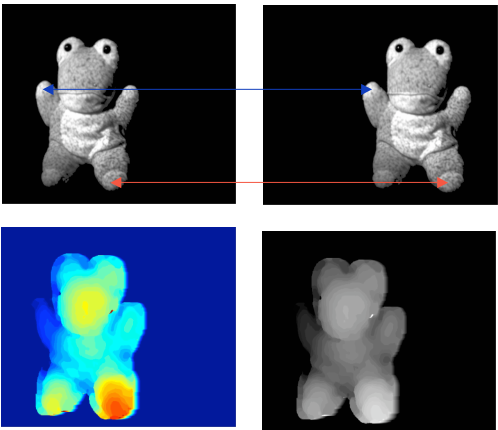
This notebook extends the examples of OpenCV applications to Stereo Block Matching. Here we run through the process of computing stereo block matching in software, profile it and then accelerate it in hardware and measure the performance speedup. We use stereo input images from the [KITTI dataset](http://www.cvlibs.net/datasets/kitti) 
1. Program overlay
2. Run SW stereo block matching (StereoBM) and measure performance
3. Run HW stereo block matching (StereoBM) and measure performance
4. Plot performance

## Program overlay

Here we program the overlay on the FPGA, load the associated overlay library and load the PYNQ xlnk memory manager library.

In [ ]:
import cv2 #NOTE: This needs to be loaded first

# Load remap + stereoBM overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2RemapStereoBM.bit")
bs.download()
import pynq_cv.overlays.xv2RemapStereoBM as xv2

# Load xlnk memory mangager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2RemapStereoBM.so')
mem_manager = Xlnk()

## Setup helper functions

Here, we set up IPython based imshow call which encode OpenCV image data to jpeg before displaying it in the notebook. Other methods of displaying image data would perform similar conversions as well.

We also setup a colorizeDisparity function which takes a matrix of grayscale values and converts them to a color map to aid in depth visualization. Warm colors (red) are further while cool colors (blue) are closer. The spectrum is associated with COLORMAP_JET and can be seen here:



In [ ]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

def colorizeDisparity(disp):
    min,max,minLoc,maxLoc = cv2.minMaxLoc(disp)
    if(min < 0):
        disp_shift = 255.0 - ((disp - min) * (255.0/(max-min)))
    else:
        disp_shift = 255.0 - (disp * (255.0/max))
    norm_disp_shift = disp_shift.astype(np.uint8)
    disp_color = cv2.applyColorMap(norm_disp_shift, cv2.COLORMAP_JET);
    return disp_color

## View example input images (left and right) 

Because our USB camera cannot capture stereo images, we read the images from a file. These KITTI color images have a resolution of 1242x375 which we then convert to gray scale.

In [ ]:
leftImage  = cv2.imread('images/000005_10_L.png')
leftY      = cv2.cvtColor(leftImage, cv2.COLOR_BGR2GRAY)
rightImage = cv2.imread('images/000005_10_R.png')
rightY     = cv2.cvtColor(rightImage, cv2.COLOR_BGR2GRAY)
imshow(leftY)
imshow(rightY)

## Run SW StereoBM and measure performance
We first run our vision processing pipeline (just StereoBM) in software only mode, being sure to enable profiling. We also measure overall FPS and colorize the resulting disparity map.
* [OpenCV StereoBM](https://docs.opencv.org/3.2.0/d9/dba/classcv_1_1StereoBM.html)

In [ ]:
%%prun -s cumulative -q -l 10 -T prunSW
import numpy as np
import time

height,width,channels = leftImage.shape
print ("Image shape: (" + str(width) + "," + str(height) + ")")
disparitySW = np.ones((height,width),np.float32)

num_frames       = 20

cv2Stereo = cv2.StereoBM_create(numDisparities=64, blockSize=19)
startSW=time.time()
for i in range(num_frames):
    disparitySW = cv2Stereo.compute(leftY,rightY)
stopSW=time.time()
print("Frames per second:  " + str(num_frames / (stopSW - startSW)))

imshow(colorizeDisparity(disparitySW))

## Process SW profile results

In [ ]:
print(open('prunSW','r').read())
res = !cat prunSW | grep StereoMatcher | awk '{{print $$2}}'
tottime_sw_stereobm = float(res[0])

## Run HW StereoBM and measure performance
Now we take advantage of the library of accelerators in our overlay and accelerate the same StereoBM OpenCV function in hardware. From a function signature point of view, it's about as simple as replacing the OpenCV library call (cv2) with a python-extended Xilinx OpenCV function call (xv2) provided to us by the overlay. 
* [xFOpenCV StereoBM](https://github.com/Xilinx/xfopencv/blob/master/include/imgproc/xf_stereoBM.hpp) ([ug1233](https://www.xilinx.com/support/documentation/sw_manuals/xilinx2018_2/ug1233-xilinx-opencv-user-guide.pdf))

In [ ]:
%%prun -s cumulative -q -l 10 -T prunHW
import numpy as np
import time

xFdisparity  = mem_manager.cma_array((height,width),np.uint16)

num_frames       = 20

xv2Stereo = xv2.StereoBM_create(numDisparities=64, blockSize=19)
startHW=time.time()
for i in range(num_frames):
    xv2Stereo.compute(leftY,rightY,xFdisparity)
    #xv2Stereo.compute(xFleft,xFright,xFdst)
stopHW=time.time()
print("Frames per second:  " + str(num_frames / (stopHW - startHW)))

imshow(colorizeDisparity(xFdisparity))

## Process HW profile results

In [ ]:
print(open('prunHW','r').read())
res = !cat prunHW | grep StereoBM | awk '{{print $$2}}'
tottime_hw_stereobm = float(res[0])

## Plot performance
In addition to having easy access to OpenCV functions, we can access functions from pyPlot for plotting results in graphs and charts. Here, we take the recorded time data and plot out the processing times in a bar chart along with computed FPS of the StereoBM function. 

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

TIME_SW_HW   = [t*1000/num_frames for (t) in (tottime_hw_stereobm, tottime_sw_stereobm)]
FPS_SW_HW    = [1000/t for (t) in (TIME_SW_HW)]
LABELS       = ['StereoBM (HW)','StereoBM(SW)']

f, ((ax1, ax2)) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))
plt.yticks(x_pos, LABELS)

ax1.barh(x_pos, TIME_SW_HW, height=0.6, color='g', zorder=3)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time per frame [ms]")
ax1.grid(zorder=0)

ax2.barh(x_pos, FPS_SW_HW, height=0.6, color='b', zorder=3)
ax2.invert_yaxis()
ax2.set_xlabel("Frames per second")
ax2.grid(zorder=0)

plt.show()

<font color=red size=4>IMPORTANT NOTE</font>: Be sure to run the cell below, shutting down the notebook, before starting a new one. The notebook interface shows "No Kernel", the cell below will incorrectly show a running status [ * ]. You can ignore this an safely close the tab of the notebook.

In [ ]:
%%javascript
Jupyter.notebook.session.delete();